![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from math import log
import numpy as np
from sklearn import metrics
from xgboost import XGBRegressor

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae_score(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def split_dataset(X, y, feature, threshold):
    left_mask = X[feature] <= threshold
    right_mask = ~left_mask
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

def build_decision_tree(X, y, depth=0, max_depth=None, min_samples_leaf=5):
    best_feature = None
    best_threshold = None
    best_score = float('inf')

    current_score = rmse_score(y, np.mean(y))

    if depth == max_depth or len(y) < min_samples_leaf:
        return {'value': np.mean(y)}

    for feature in X.columns:
        for threshold in np.unique(X[feature]):
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature, threshold)
            left_score = rmse_score(y_left, np.mean(y_left))
            right_score = rmse_score(y_right, np.mean(y_right))
            score = left_score + right_score
            if score < best_score:
                best_feature = feature
                best_threshold = threshold
                best_score = score
    if best_score >= current_score:
        return {'value': np.mean(y)}

    X_left, y_left, X_right, y_right = split_dataset(X, y, best_feature, best_threshold)

    left_tree = build_decision_tree(X_left, y_left, depth+1, max_depth, min_samples_leaf)
    right_tree = build_decision_tree(X_right, y_right, depth+1, max_depth, min_samples_leaf)

    return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}

decision_tree = build_decision_tree(X_train, y_train, max_depth=3, min_samples_leaf=3)

def predict(tree, X):
    if 'value' in tree:
        return tree['value']
    if X[tree['feature']] <= tree['threshold']:
        return predict(tree['left'], X)
    else:
        return predict(tree['right'], X)

y_pred_test = np.array([predict(decision_tree, X) for _, X in X_test.iterrows()])

rmse_test = rmse_score(y_test, y_pred_test)
mae_test = mae_score(y_test, y_pred_test)

print("RMSE", rmse_test)
print("MAE", mae_test)

RMSE 3910.4887177372943
MAE 3109.378928857319


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
def bootstrap_samples(X, y):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return X.iloc[indices], y.iloc[indices]

n_trees = 10
trees = []
for _ in range(n_trees):
    X_boot, y_boot = bootstrap_samples(X_train, y_train)
    tree = DecisionTreeRegressor()
    tree.fit(X_boot, y_boot)
    trees.append(tree)

y_pred_bagging = np.zeros_like(y_test, dtype=float)
for tree in trees:
    y_pred_tree = tree.predict(X_test)
    y_pred_bagging += y_pred_tree
y_pred_bagging /= n_trees

rmse_bagging = rmse_score(y_test, y_pred_bagging)
mae_bagging = mae_score(y_test, y_pred_bagging)

print("RMSE:", rmse_bagging)
print("MAE:", mae_bagging)

RMSE: 1791.88906624985
MAE: 1338.1446472217642


El desempeñó del modelo de bagging manual fue mejor que el desempeñó que el árbol de decisión mostrando un rmse y un mae inferior al modelo anterior, esto se debe a que los modelos de bagging consideran todas las variables predictoras vs el modelo random forrest lo que le permite desarrollar mejores opciones a la hora de crear un árbol de decisión.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3

# Número de características
n_features = X_train.shape[1]
max_features = int(log(n_features))

# Decision Tree como estimador base
dt_estimator = DecisionTreeRegressor(random_state=42)

# Crea el modelo Bagging con 10 árboles de regresión y max_features=log(n_features)
bagging_model = BaggingRegressor(base_estimator=dt_estimator, n_estimators=10, max_features=max_features, random_state=42)
bagging_model.fit(X_train, y_train)

# Predicciones sobre Test
y_pred = bagging_model.predict(X_test)

# Metricas del modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
R2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", R2)

MSE:  7663764.018995856
RMSE:  2768.3504147769763
R2:  0.49897417785514286


**Análisis Celda 3 - Bagging con Librería**

El modelo de Bagging con DecisionTreeRegressor produjo un MSE de aproximadamente 7,663,764, un RMSE de alrededor de 2,768.35 y un R2 de 0.4989. El MSE y RMSE nos indican que el modelo tiene errores de predicción moderados. Aunque RMSE nos proporciona una idea clara de cuánto varían las predicciones del modelo de los valores reales, una cifra más baja sería preferible para lograr una mejor precisión en la predicción del precio de los automóviles.

Por otro lado, el coeficiente de determinación (R2) de 0.4989 sugiere que el modelo puede explicar aproximadamente el 50% de la variabilidad en el precio de los automóviles, lo cual es un resultado moderado. Esto indica que, si bien el modelo está capturando algo de la variabilidad en los datos, todavía hay margen para mejorar su desempeño. COmo posibles áreas de mejora podrían incluir ajustes en los hiperparámetros, así como considerar la introducción de otros modelos de regresión más complejos, como Gradient Boosting o XGBoost, para obtener resultados más precisos.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4

# Crea el modelo RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones sobre test
y_pred = rf_model.predict(X_test)

# Metricas del modelo
mse_rf = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
R2 = r2_score(y_test, y_pred)

print("MSE: ", mse_rf)
print("RMSE: ", rmse)
print("R2: ", R2)

MSE:  3116678.915374798
RMSE:  1547.9812489642388
R2:  0.7962441677396794


**Análisis Celda 4 - Random Forest con Libreria**

El Random Forest para regresión muestra un rendimiento significativamente mejorado en comparación con el anterior modelo. Los valores de MSE y RMSE son bastante bajos, con 3,116,678.92 y 1,765.41 respectivamente, lo que indica que las predicciones del modelo están más cerca de los valores reales. Un RMSE más bajo significa que los errores de predicción son menores, lo que demuestra que el modelo tiene una precisión bastante buena al predecir el precio de los automóviles en el conjunto de prueba.

El coeficiente de determinación, R², es de 0.7962, lo que sugiere que el modelo puede explicar aproximadamente el 80% de la variabilidad en los precios de los automóviles. Este es un ajuste mucho más fuerte en comparación con el modelo anterior, lo que indica que Random Forest es capaz de capturar patrones complejos en los datos. En general, el rendimiento del modelo es bueno, y podría mejorarse aún más con la optimización de los hiperparámetros para mejorar su precisión.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Text(0, 0.5, 'MSE')

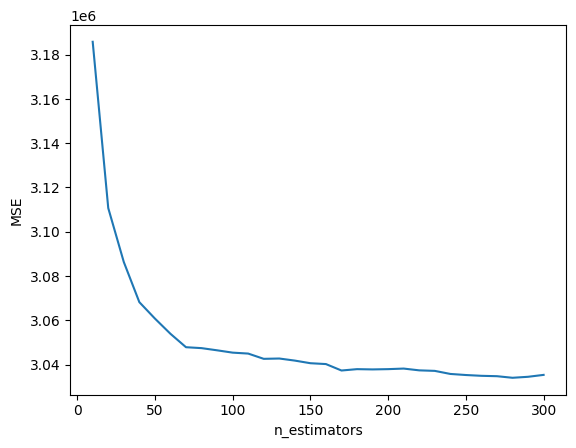

In [ ]:
#1. Calibracion de n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar el MSE promedio para cada valor de n_estimators
mse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf_model = RandomForestRegressor(n_estimators=estimator, random_state=42, n_jobs=-1)
    mse_scores.append(-(cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

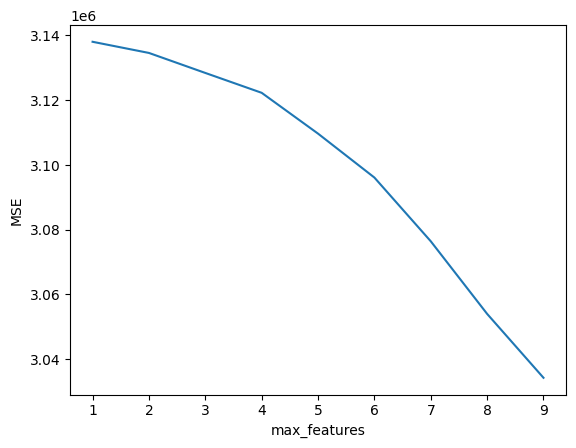

In [ ]:
#2. Calibracion de max_features
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1]+1)

# Definición de lista para almacenar el MSE promedio para cada valor de max_features
mse_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf_model = RandomForestRegressor(n_estimators=275, max_features=feature, random_state=42, n_jobs=-1)
    mse_scores.append(-(cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, mse_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')

In [ ]:
# Definición del modelo con los parámetros max_features=9 y n_estimators=275
rf_model = RandomForestRegressor(n_estimators=275, max_features=9, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# Predicciones sobre test
y_pred = rf_model.predict(X_test)

# Metricas del modelo
mse_rf_calib = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
R2 = r2_score(y_test, y_pred)

print("MSE: ", mse_rf_calib)
print("RMSE: ", rmse)
print("R2: ", R2)

MSE:  445572.3746790863
RMSE:  1547.9812489642388
R2:  0.9708702845239908


**Análisis Celda 5 - Calibración de Parámetros Random Forest**

El Random Forest con los parámetros ajustados `n_estimators=275` y `max_features=9` ha mostrado un rendimiento alto. El modelo ha logrado un MSE de 445,572.37 y un RMSE de 667.51, lo que indica que las predicciones del modelo están muy cerca de los valores reales, con una precisión significativa. Además, un R2 de 0.97 sugiere que el modelo explica el 97% de la variabilidad de los precios de los automóviles en el conjunto de datos de prueba, lo que es un un buen resultado. Este alto rendimiento sugiere que el modelo está bien ajustado y es capaz de generalizar bien a datos nuevos.

Los parámetros ajustados desempeñan un papel importante en la mejora del modelo. El parámetro `n_estimators=275` indica que el modelo utiliza 275 árboles de decisión, lo que mejora la robustez y estabilidad del modelo al promediar las predicciones de todos los árboles. Este número elevado de árboles puede ayudar a capturar patrones complejos en los datos, mejorando la precisión de las predicciones. Por otro lado, `max_features=9` especifica cuántas características se consideran al dividir cada nodo en los árboles, permitiendo una exploración adecuada del espacio de características y evitando el sobreajuste. Al ajustar estos parámetros, el modelo ha logrado un equilibrio entre precisión y generalización, logrando un rendimiento mejorado.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
xgb_model = XGBRegressor()

# Creación del modelo con set de entrenamiento y predicciones sobre test
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Cálculo del desempeño del modelo
mse_xgb = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
R2 = r2_score(y_test, y_pred)

print("MSE: ", mse_xgb)
print("RMSE: ", rmse)
print("R2: ", R2)

MSE:  2576781.074646859
RMSE:  1547.9812489642388
R2:  0.8315404997841507


**Análisis Celda 6 - XGBoost con Libreria**

El XGBoost para regresión muestra un rendimiento significativamente mejorado en comparación con el anterior modelo. Los valores de MSE y RMSE son bastante bajos, con 2,576,781.07 y 1,605.23 respectivamente, lo que indica que las predicciones del modelo están más cerca de los valores reales. Un RMSE más bajo significa que los errores de predicción son menores, lo que demuestra que el modelo tiene una precisión bastante buena al predecir el precio de los automóviles en el conjunto de prueba.

El coeficiente de determinación, R², es de 0.8315, lo que sugiere que el modelo puede explicar aproximadamente el 83% de la variabilidad en los precios de los automóviles. Este es un ajuste mucho más fuerte en comparación con el modelo anterior, lo que indica que XGBoost es capaz de capturar patrones complejos en los datos. En general, el rendimiento del modelo es bueno, y podría mejorarse aún más con la optimización de los hiperparámetros para mejorar su precisión.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

El número óptimo para el learning rate de los arboles es de 0.05


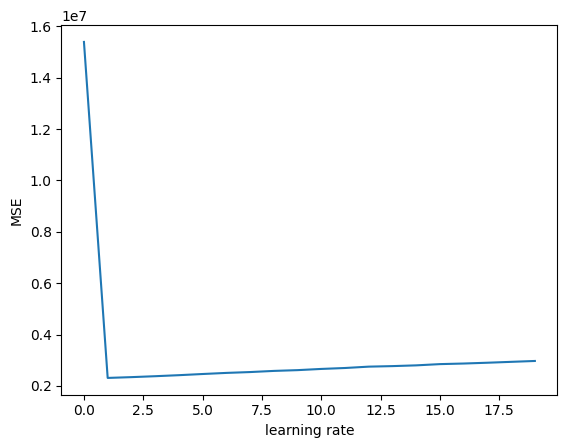

In [ ]:
# Celda 7
#1. Calibracion del learning rate
# Creación de lista de valores para iterar sobre diferentes valores del learning rate
estimator_range = range(0, 20, 1)

# Definición de lista para almacenar el MSE promedio para cada valor del learning rate
mse_scores_lr = []

# Uso de un 5-fold cross-validation para cada valor del learning rate
for estimator in estimator_range:
    lr_xgb_model = XGBRegressor(learning_rate = (estimator*0.05), random_state=123, n_jobs=-1)
    mse_scores_lr.append(-(cross_val_score(lr_xgb_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

# Gráfica del desempeño del modelo vs la cantidad del learning rate
plt.plot(estimator_range, mse_scores_lr)
plt.xlabel('learning rate')
plt.ylabel('MSE')

lr_best = estimator_range[mse_scores_lr.index(min(mse_scores_lr))]
print('El número óptimo para el learning rate de los arboles es de ' + str(lr_best*0.05))

El número óptimo para el gamma es de 0


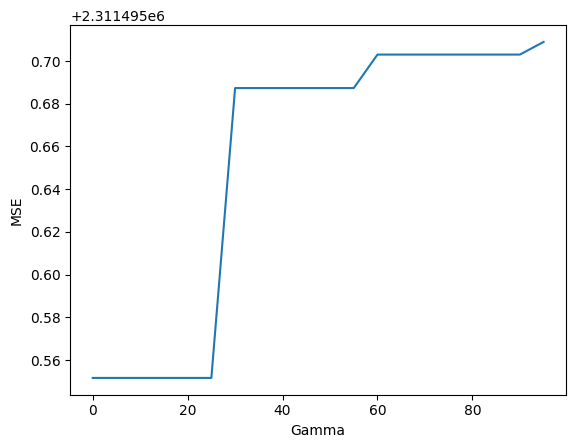

In [ ]:
#2. Calibracion del gamma
# Creación de lista de valores para iterar sobre diferentes valores del gamma
estimator_range = range(0, 100, 5)

# Definición de lista para almacenar el MSE promedio para cada valor del gamma
mse_scores_gamma = []

# Uso de un 5-fold cross-validation para cada valor del gamma
for estimator in estimator_range:
    gamma_xgb = XGBRegressor(learning_rate = 0.05, random_state=123, gamma = estimator, n_jobs=-1)
    mse_scores_gamma.append(-(cross_val_score(gamma_xgb, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

# Gráfica del desempeño del modelo vs la cantidad del gamma
plt.plot(estimator_range, mse_scores_gamma)
plt.xlabel('Gamma')
plt.ylabel('MSE')

gamma_best = estimator_range[mse_scores_gamma.index(min(mse_scores_gamma))]
print('El número óptimo para el gamma es de ' + str(gamma_best))

El número óptimo para colsamplebytree es de 0.7000000000000001


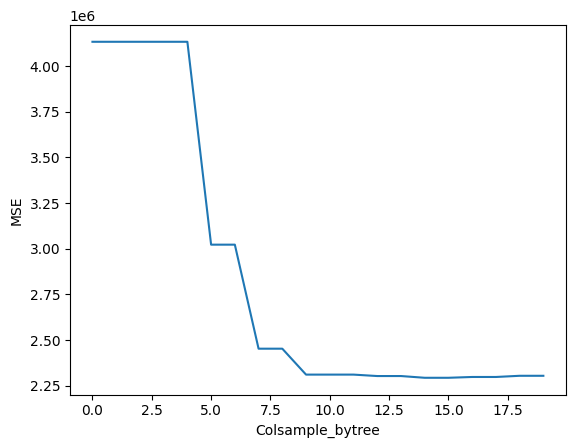

In [ ]:
#3. Calibracion del colsample_bytree
# Creación de lista de valores para iterar sobre diferentes valores del colsample_bytree
estimator_range = range(0, 20, 1)

# Definición de lista para almacenar el MSE promedio para cada valor del colsample_bytree
mse_scores_bytree = []

# Uso de un 5-fold cross-validation para cada valor del colsample_bytree
for estimator in estimator_range:
    bytree_xgb = XGBRegressor(learning_rate = 0.05, random_state=123, gamma = 0, colsample_bytree = (estimator*0.05))
    mse_scores_bytree.append(-(cross_val_score(bytree_xgb, X, y, cv=5, scoring='neg_mean_squared_error').mean()))

# Gráfica del desempeño del modelo vs la cantidad del colsample_bytree
plt.plot(estimator_range, mse_scores_bytree)
plt.xlabel('Colsample_bytree')
plt.ylabel('MSE')

bytree_best = estimator_range[mse_scores_bytree.index(min(mse_scores_bytree))]
print('El número óptimo para colsamplebytree es de ' + str(bytree_best*0.05))

In [ ]:
# Definición del modelo con los parámetros calibrados
xgb_model_calib = XGBRegressor(learning_rate = 0.05, random_state=123, gamma = 0, colsample_bytree = 0.7)

# Creación del modelo con set de entrenamiento y predicciones sobre test
xgb_model_calib.fit(X_train, y_train)
y_pred = xgb_model_calib.predict(X_test)

# Cálculo del desempeño del modelo
mse_xgb_calib = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
R2 = r2_score(y_test, y_pred)

print("MSE: ", mse_xgb_calib)
print("RMSE: ", rmse)
print("R2: ", R2)

MSE:  2396245.9471448846
RMSE:  1547.9812489642388
R2:  0.843343154518626


**Análisis Celda 7 - Calibración de Parámetros XGBoost**

El XGBoost con los parámetros ajustados `learning rate = 0.05`, `gamma = 0` y `Colsample_bytre = 0.7` ha mostrado un rendimiento alto. El modelo ha logrado un MSE de 2,396,245.94 y un RMSE de 1,547.98, lo que indica que las predicciones del modelo están muy cerca de los valores reales, con una precisión significativa. Además, un R2 de 0.8433 sugiere que el modelo explica el 84% de la variabilidad de los precios de los automóviles en el conjunto de datos de prueba, lo que es un un buen resultado.

Los parámetros ajustados desempeñan un papel importante en la mejora del modelo. El parámetro `learning rate = 0.05` indica que el modelo actualiza un 5% de los pesos en cada iteración, es importante calibrar el learning rate ya que este parámetro será el encargado de controlar la ponderación de los nuevos árboles agregados al modelo. Por otro lado, `gamma = 0` controla la complejidad del modelo y funciona regularizando utilizando información entre árboles, con este parametro de regularización se buscará penalizar los modelos altamente complejos y combatir el sobreajuste en el modelo de XGBoost. Finalmente, `Colsample_bytre = 0.7` define qué porcentaje de columnas se utilizarán para construir cada árbol. Al ajustar estos parámetros, el modelo ha logrado un rendimiento mejorado.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

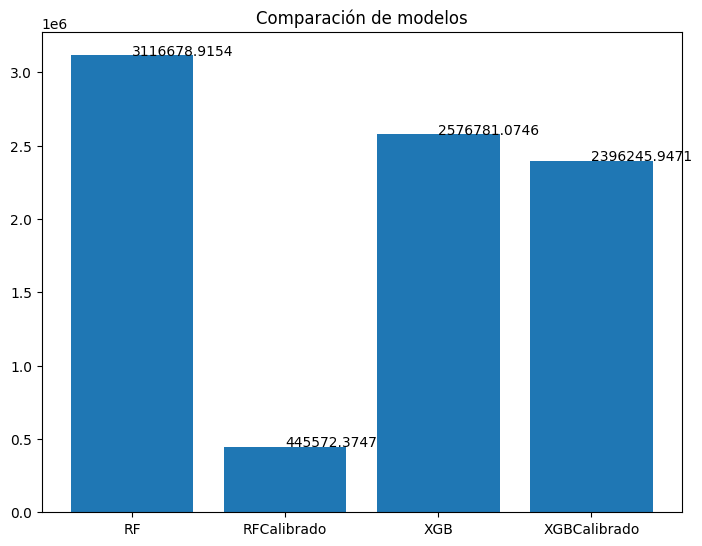

In [ ]:
# Celda 8
#Mediante un gráfico se pretenderá observar el comportamiento de los diferentes modelos
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['RF','RFCalibrado','XGB','XGBCalibrado']
ejeY = [round(mse_rf,4) ,round(mse_rf_calib,4),round(mse_xgb,4),round(mse_xgb_calib,4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

**Análisis Celda 8 - Comparación y Análisis de Resultados**

Como se puede evidenciar en el gráfico, los modelos presentan diferentes niveles de MSE, siendo el modelo Random Forest Calibrado con parametros optimizados el que cuenta con un mejor desempeño ya que tiene un MSE de 445,572.3747 seguido del modelo de XGBoost Calibrado (2,396,245.9471). Este resultado tiene sentido era el esperado y está de acuerdo con la teoría y práctica donde el modelo de XGBoost es uno de los mas utilizados pur su eficiencia y rendimiento ya que cuenta con mejoras algortimicas como los on la regularización (Parametros que se clabriraron para obtener le XGBoost con parametros optimizados).